## Rum Yue
## Exercise on NYC taxi trip duration prediction

### 1) Data cleaning
### 2) Model selection & training

In [1]:
%%HTML
<button onclick="$('.input, .prompt, .output_stderr, .output_error, .output_result').toggle();">Toggle Code</button>

## Packages

In [7]:
#!pip install google.cloud
#!pip install google.cloud.bigquery
!pip install lightgbm

In [8]:
%matplotlib inline
from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns
import datetime as dt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

## Data cleaning

In [228]:

raw= pd.read_csv("train.csv", nrows=10000, parse_dates=['pickup_datetime','dropoff_datetime'])

In [143]:
#plt.style.use('fivethirtyeight')
#plt.rcParams["patch.force_edgecolor"] = True
pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/xlyue/Downloads/APMA E 4990-a7a892335efd.json"

In [144]:
def getdata():
    client = bigquery.Client()
    pd.set_option('mode.chained_assignment', None)

    query = (
            """
            SELECT pickup_datetime,pickup_longitude,pickup_latitude,
            dropoff_longitude, dropoff_latitude, passenger_count,
            DATETIME_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016` 
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and dropoff_longitude IS NOT NULL 
            ORDER BY RAND()
            LIMIT 1500000"""
            )
    df=pd.io.gbq.read_gbq(query,dialect='standard')

    return df

In [145]:
#get train data 
#raw=getdata()

In [146]:
#!pip install pandas-gbq
#!conda install pandas-gbq -c conda-forge

In [229]:
train=raw.copy()

### Latitude and Longitude

In this part, we removed data whose location is outside of NYC based on latitude and longitude.

In [148]:
#limit latitude and longitude within the range of nyc (based on google map)
def lat_long(train):
    train = train[(train.pickup_longitude > -74.25) & (train.pickup_longitude < -73.70)]
    train = train[(train.pickup_latitude > 40.49) & (train.pickup_latitude < 40.91)]
    train = train[(train.dropoff_longitude > -74.25) & (train.dropoff_longitude < -73.70)]
    train = train[(train.dropoff_latitude > 40.49) & (train.dropoff_latitude < 40.91)]
    
    #show the plot of pickup locations
    p_lng = train['pickup_longitude'].values
    p_lat = train['pickup_latitude'].values
    d_lng = train['dropoff_longitude'].values
    d_lat = train['dropoff_latitude'].values
    
    plt.figure(figsize = (12, 8))
    plt.grid(False)
    plt.rcParams['savefig.dpi'] = 300
    #plt.rcParams['figure.dpi'] = 300
    plt.plot(p_lng, p_lat, '.', alpha = .4, markersize = .8)
    plt.plot(d_lng, d_lat, '.', alpha = .4, markersize = .8)

    plt.title('Pickup & Dropoff Trip Plots')
    plt.show()
    
    return train

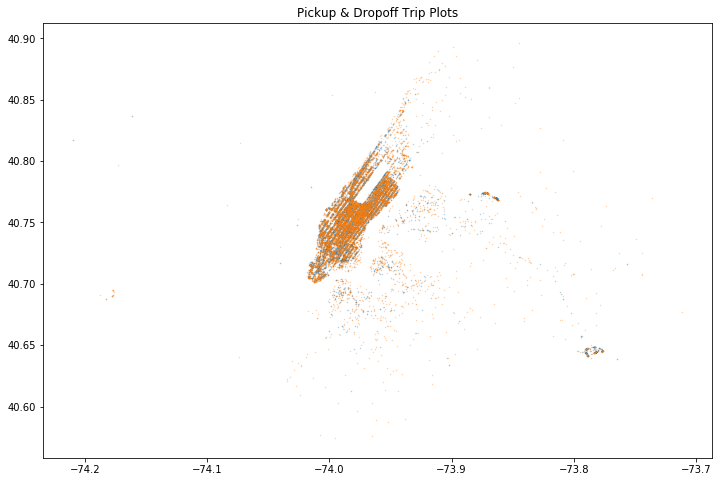

In [230]:
train=lat_long(train)

### Passenger count 
Discard records with zero passengers and nine passengers since these two cases are unreasonable both for taxi trip and policy.

In [150]:
def passenger(train):
    train = train[(train.passenger_count > 0) & (train.passenger_count < 9)]
    
    return train

In [151]:
train = passenger(train)

### Travel time

Only kept data whose travel time is larger than 10 seconds and less than 8 hours(Longest uber trip in NYC histroy: https://nypost.com/2016/12/10/the-longest-ride-in-uber-history/). And we found that travel time subject ot lognormal distribution. 

Because difference between travel times is huge (some trips only took few minutes while others took hours), we took its log value as our feature.

In [152]:
#show the distribution of travel time, remove outliers
def travel_time(data):
    #remove data whose travel time is less than 10 seconds
    data=data[data['travel_time']>10]
    #remove data whose travel time is more than 8 hours
    data=data[data['travel_time']<30000]
    plt.figure(figsize=(12,6))
    plt.grid(False)
    plt.hist(data['travel_time'],bins=500, label = 'trip duration', rwidth = 0.9)
    plt.xlabel('travel time (seconds)')
    plt.xlim(-100,6000)
    plt.title('travel time distribution')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12,6))
    data['travel_time']=np.log(data['travel_time'].copy())
    plt.grid(False)
    plt.hist(data['travel_time'],bins=100, label = 'trip duration', rwidth = 0.9)
    plt.xlabel('travel time (log seconds)')
    plt.title('travel time distribution (after taking log)')
    plt.legend()
    plt.show()
    return data
   

### Time features: hours, week and month

In this section we showed that time in a day is an important feature, while weeday and month are not.

In [153]:
#analysis the distribution among time
def time(train):
    train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime).copy()
    train['month'] = train.pickup_datetime.dt.month.copy()
    train['week'] = train.pickup_datetime.dt.week.copy()
    train['weekday'] = train.pickup_datetime.dt.weekday.copy()
    train['hour'] = train.pickup_datetime.dt.hour.copy()
    train['minute'] = train.pickup_datetime.dt.minute.copy()
    train['minute_oftheday'] = train['hour'] .copy()* 60 + train['minute'].copy()
    train.drop(['minute'], axis=1, inplace=True)

    
    wkd_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    plt.figure(figsize = (12, 3))
    data_wkd = train.groupby('weekday').aggregate({'pickup_datetime': 'count'}).reset_index()
    sns.barplot(x = 'weekday', y = 'pickup_datetime', data = data_wkd)
    plt.title('amount of trip records distribution')
    plt.xlabel('weekday')
    plt.xticks(range(0, 7), wkd_names)
    plt.ylabel('amount of trips')
    plt.show()
    
    mt_names = ['January', 'February', 'March', 'April', 'May', 'June']
    plt.figure(figsize = (12, 3))

    data_mt = train.groupby('month').aggregate({'pickup_datetime': 'count'}).reset_index()
    sns.barplot(x = 'month', y = 'pickup_datetime', data = data_mt)

    plt.title('amount of trip records distribution')
    plt.xlabel('month')
    plt.xticks(range(0, 6), mt_names)
    plt.ylabel('amount of trips')
    plt.show()
    plt.figure(figsize = (12, 3))

    data_h = train.groupby('hour').aggregate({'pickup_datetime': 'count'}).reset_index()
    sns.barplot(x = 'hour', y = 'pickup_datetime', data = data_h)

    plt.title('amount of trip records distribution')
    plt.xlabel('hour of a day: 0 - 23')
    plt.ylabel('amount of trips')
    plt.show()
    return train

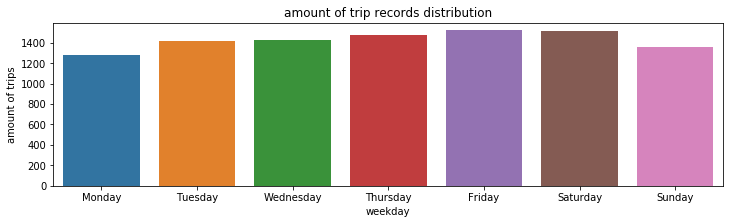

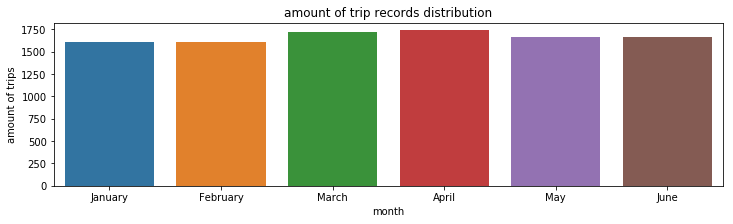

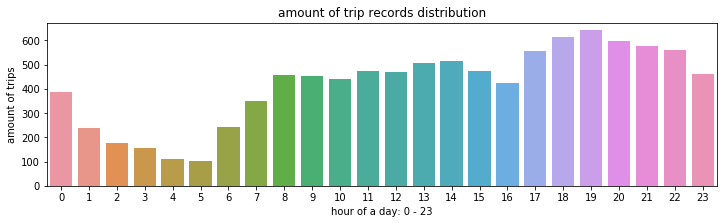

In [231]:
train=time(train)

From the 3 plots above we can see that the amount of trips does not vary much across weekdays and months, but does flunctuate within one day.
So we take time in a day as a feature.

In [155]:
#heatmap for hour & weekday
def heatmap(train):
    plt.figure(figsize = (12, 3))
    
    sns.heatmap(data = pd.crosstab(train['weekday'], train['hour'], values = train.pickup_datetime,
                                   aggfunc = 'count', normalize = 'index'), cmap='BuPu')
    wkd_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    plt.title('trip amount heatmap of weekday & hour')
    plt.xlabel('hour of a day: 0 - 23')
    plt.ylabel('weekday')
    plt.yticks(range(0, 7), wkd_names, rotation = '20')
    plt.show()
    #heatmap for weekday & month
    mt_names = ['January', 'February', 'March', 'April', 'May', 'June']
    fig1=plt.figure(figsize = (12, 3))
    sns.heatmap(data = pd.crosstab(train['month'], train['weekday'], values = train.pickup_datetime, 
                                   aggfunc = 'count', normalize = 'index'), cmap='Blues')
    plt.title('trip amount heatmap of month & weekday')
    plt.xlabel('weekday')
    plt.xticks(range(0, 7), wkd_names, rotation = '10')
    plt.ylabel('month')
    plt.yticks(range(0, 6), mt_names, rotation = '0')
    plt.show()
    train.drop(['pickup_datetime'], axis=1, inplace=True)
    train.drop(['hour'],axis=1,inplace=True)
    
    return train

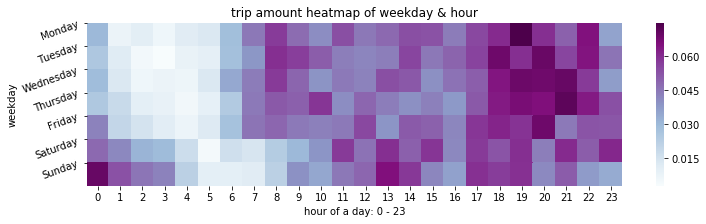

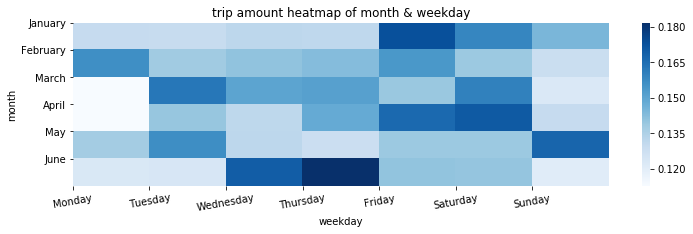

In [232]:
train=heatmap(train)

### Distance & Speed

Calculated Haversine distance based on longitudes and latitudes. Removed distance that is larger than the diameter of NYC (60 km) or is too short (less than 10 meters). Demonstrate the distance distribution.

Calculated approximating speed based on Haversine distance and travel time. The aim is to remove outliers whose speed is abnormally large. Those outliers might elude previous cleaning because their travel time and distance seem normal when judging seperately.

In [157]:
def haversine(lat1, lon1, lat2, lon2):
    r=6371.0 # average radius of earth
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    distance=2 * r * np.arcsin(np.sqrt(a))
    return distance

In [158]:
#compute distance based on longitudes and latitudes, show the distribution of distance, remove outliers
def distance(train):
    train['distance'] = haversine(train['pickup_latitude'].values.copy(), train['pickup_longitude'].values.copy(),\
                                  train['dropoff_latitude'].values.copy(), train['dropoff_longitude'].values.copy())
    #the diameter of new york city is less than 60 km 
    train=train[train['distance']<60]
    train=train[train['distance']>0.01]
    plt.figure(figsize = (12, 8))
    plt.hist(train['distance'], bins=200,label = 'distance', rwidth = 0.9)
    plt.xlabel('Direct distance between pickup and dropoff locations(km)')
    plt.ylabel('Count')
    plt.title('Distribution of distance')
    plt.legend()
    plt.show()
    
    train['speed']= train.distance.copy() / (np.exp(train.travel_time.copy())/3600.0)
    train=train[train['speed']<500]
    plt.figure(figsize=(12,8))
    plt.hist(train.speed, bins=500,label = 'speed', rwidth = 0.9)
    plt.xlim(-10,300)
    plt.xlabel('Approximating average travel speed (km/h)')
    plt.ylabel('Count')
    plt.title('Distribution of speed')
    plt.legend()
    plt.show()
    train.drop(['speed'], axis=1, inplace=True)
    return train

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
id                    1000 non-null object
vendor_id             1000 non-null int64
pickup_datetime       1000 non-null datetime64[ns]
dropoff_datetime      1000 non-null datetime64[ns]
passenger_count       1000 non-null int64
pickup_longitude      1000 non-null float64
pickup_latitude       1000 non-null float64
dropoff_longitude     1000 non-null float64
dropoff_latitude      1000 non-null float64
store_and_fwd_flag    1000 non-null object
trip_duration         1000 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 86.0+ KB


In [233]:
train['travel_time'] = (df.dropoff_datetime-df.pickup_datetime)/ np.timedelta64(1,"m")

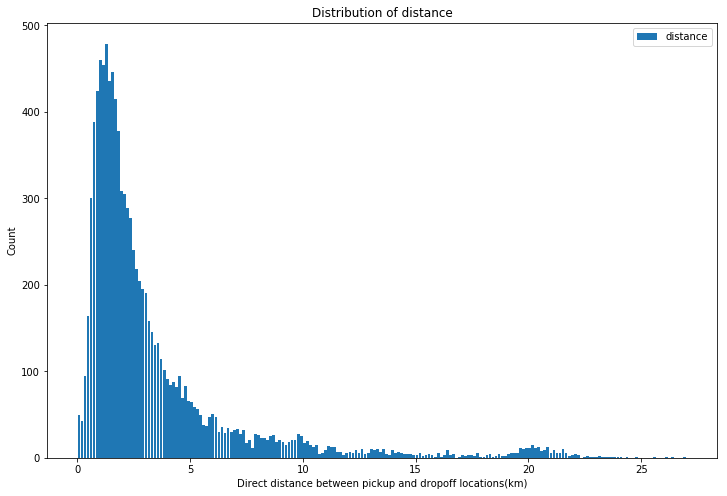

D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


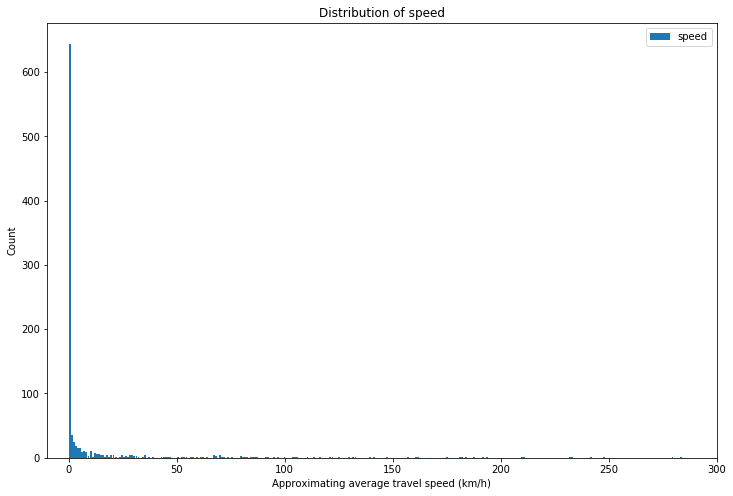

In [234]:
train=distance(train)

### Direction feature

The direction from pickup point to dropoff point.

In [169]:
def ft_degree(lat1, lng1, lat2, lng2):
    #r = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    
    return np.degrees(np.arctan2(y, x))

In [170]:
#Direction feature
def direction(train):
    train['direction'] = ft_degree(train['pickup_latitude'].copy().values, train['pickup_longitude'].copy().values, \
                               train['dropoff_latitude'].copy().values, train['dropoff_longitude'].copy().values)
    return train

In [236]:
train=direction(train)

In [237]:
train.head()

,id,vendor_id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,week,weekday,minute_oftheday,travel_time,distance,direction
0,id2875421,2,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,11,0,1044,7.583333,1.498521,99.970196
1,id2377394,1,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,23,6,43,11.050000,1.805507,-117.153768
2,id3858529,2,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,3,1,695,35.400000,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,14,2,1172,7.150000,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,12,5,810,7.250000,1.188588,179.473585


In [173]:
def show_corr(train):
    plt.figure(figsize = (18, 6))
    features=train.copy()
    sns.heatmap(data = features.corr(), annot = True, cmap = plt.cm.RdYlBu_r, linewidths=.1)

    plt.title('Correlations between variables')
    plt.show()

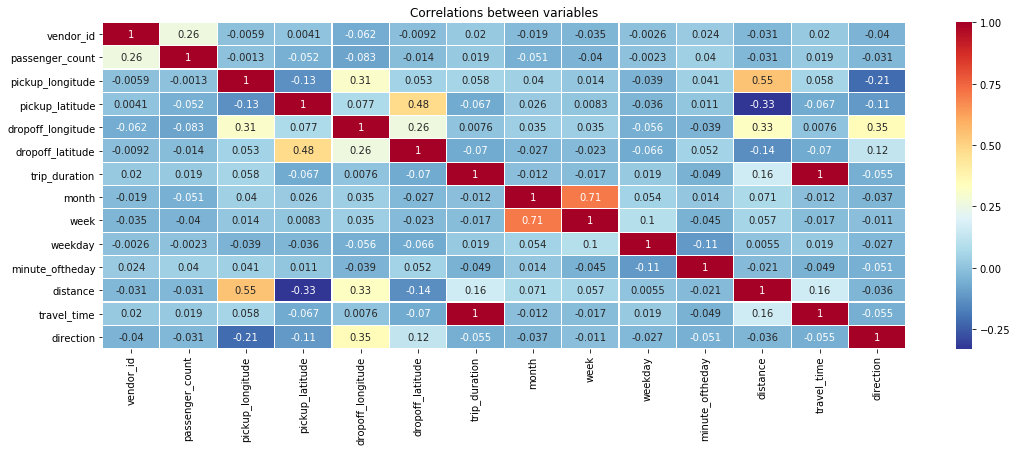

In [174]:
show_corr(train)

### Test data preprocessing 

Generate features we need.

In [175]:
def preprocess(test):
    test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime).copy()
    test['month'] = test.pickup_datetime.dt.month.copy()
    test['week'] = test.pickup_datetime.dt.week.copy()
    test['weekday'] = test.pickup_datetime.dt.weekday.copy()
    test['hour'] = test.pickup_datetime.dt.hour.copy()
    test['minute'] = test.pickup_datetime.dt.minute.copy()
    test['minute_oftheday'] = test['hour'] .copy()* 60 + test['minute'].copy()
    test.drop(['minute'], axis=1, inplace=True)
    test.drop(['hour'], axis=1, inplace=True)
    test.drop(['pickup_datetime'], axis=1, inplace=True)
    test['distance'] = haversine(test['pickup_latitude'].values.copy(), test['pickup_longitude'].values.copy(),
                                  test['dropoff_latitude'].values.copy(), test['dropoff_longitude'].values.copy())
    test['direction']= ft_degree(test['pickup_latitude'].copy().values, test['pickup_longitude'].copy().values, 
                               test['dropoff_latitude'].copy().values, test['dropoff_longitude'].copy().values)
    return test

In [240]:
#test=preprocess(pd.read_csv('APM4990_final_test_data_filtered.csv'))
#test=preprocess(pd.read_csv('test.csv'))
#, parse_dates=['pickup_datetime','dropoff_datetime']
test= preprocess(pd.read_csv("test.csv", nrows=1000))
#test['travel_time'] = (test.dropoff_datetime-test.pickup_datetime)/ np.timedelta64(1,"m")

In [241]:
test.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,month,week,weekday,minute_oftheday,distance,direction
0,id3004672,1,1,-73.988129,40.732029,-73.990173,40.756680,N,6,26,3,1439,2.746426,-3.595224
1,id3505355,1,1,-73.964203,40.679993,-73.959808,40.655403,N,6,26,3,1439,2.759239,172.278835
2,id1217141,1,1,-73.997437,40.737583,-73.986160,40.729523,N,6,26,3,1439,1.306155,133.326248
3,id2150126,2,1,-73.956070,40.771900,-73.986427,40.730469,N,6,26,3,1439,5.269088,-150.956833
4,id1598245,1,1,-73.970215,40.761475,-73.961510,40.755890,N,6,26,3,1439,0.960842,130.260381


## Model selection & training

### Model preparation

In [242]:
def data_split(train):
    y = train['travel_time']
    train.drop(['travel_time'], axis = 1, inplace =True)
    X = train.copy()
    z_1 = train.copy()
    z_2 = y.copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    X_train_2, X_dev, y_train_2, y_dev = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
    
    return X_train, X_test, y_train, y_test, X_train_2, X_dev, y_train_2, y_dev, z_1, z_2

In [254]:
train['travel_time'] = (df.dropoff_datetime-df.pickup_datetime)/ np.timedelta64(1,"m")

In [249]:
train1=train.copy()

In [250]:
train.drop(columns="id", inplace=True)

In [255]:
d_set = data_split(train)

In [248]:
train.head(1)

,id,vendor_id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,week,weekday,minute_oftheday,distance,direction
0,id2875421,2,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,455,3,11,0,1044,1.498521,99.970196


### Multivariate linear model

In [244]:
def linear_model(d_set):
    lr = LinearRegression()
    lr.fit(d_set[0], d_set[2])
    train_sc = lr.score(d_set[0], d_set[2])
    test_sc = lr.score(d_set[1], d_set[3])
    y_pred_lr = lr.predict(d_set[1])
    rmse = np.sqrt(mse(d_set[3], y_pred_lr))
    v_exp = metrics.explained_variance_score(d_set[3], y_pred_lr)
    R_2 = metrics.r2_score(d_set[3], y_pred_lr)
    rmsle = np.sqrt(msle(d_set[3], y_pred_lr))
    
    print('R^2 score is {}, rmse is {}, rmsle is {}'.format(R_2, rmse, rmsle))
    print( )
    print('linear training model score is {}, test model score is {}'.format(train_sc, test_sc))
    print( )
    print('{} of the variation in the dependent variable is explained by multivariate linear model'.format(v_exp))
    
    plt.plot(d_set[3], y_pred_lr, label = 'fit')
    plt.legend()
    plt.show()

In [256]:
linear_model(d_set)

TypeError: float() argument must be a string or a number, not 'Timestamp'

#### Conclusion 
The model score of test set does not indicate obvious overfitting. 

### Random forest model

In [182]:
def rfr(d_set):
    rf = RandomForestRegressor(n_estimators=200, max_depth = 50, min_samples_split = 10, n_jobs = -1)
    rf.fit(d_set[0], d_set[2])
    train_sc = rf.score(d_set[0], d_set[2])
    test_sc = rf.score(d_set[1], d_set[3])
    y_pred_rf = rf.predict(d_set[1])
    rmse = np.sqrt(mse(d_set[3], y_pred_rf))
    v_exp = metrics.explained_variance_score(d_set[3], y_pred_rf)
    R_2 = metrics.r2_score(d_set[3], y_pred_rf)
    rmsle = np.sqrt(msle(d_set[3], y_pred_rf))
    
    print('R^2 score is {}, rmse is {}, rmsle is {}'.format(R_2, rmse, rmsle))
    print( )
    print('Random forest training model score is {}, test model score is {}'.format(train_sc, test_sc))
    print( )
    print('{} of the variation in the dependent variable is explained by random forest model'.format(v_exp))


In [183]:
%%time
rfr(d_set)

ValueError: could not convert string to float: 'id3579210'

#### Evaluation on Random forest model
Radomforest regressor takes too much time for fitting the training data set, even with original setting parameters. It is unreasonable to tune parameters using this model if we want to improve efficiency in the following sections.

### Light Gradient Boosting Machine (LightGBM)

#### Fastness and Cross Validation (in k = 5 folders)

In [184]:
def light(d_set):
    lgbR = LGBMRegressor()
    lgbR.fit(d_set[0], d_set[2])
    train_sc = lgbR.score(d_set[0], d_set[2])
    test_sc = lgbR.score(d_set[1], d_set[3])
    y_pred_lgbR = lgbR.predict(d_set[1])
    rmse = np.sqrt(mse(d_set[3], y_pred_lgbR))
    v_exp = metrics.explained_variance_score(d_set[3], y_pred_lgbR)
    R_2 = metrics.r2_score(d_set[3], y_pred_lgbR)
    rmsle = np.sqrt(msle(d_set[3], y_pred_lgbR))
    
    print('R^2 score is {}, rmse is {}, rmsle is {}'.format(R_2, rmse, rmsle))
    print( )
    print('LightGBM training model score is {}, test model score is {}'.format(train_sc, test_sc))
    print( )
    print('{} of the variation in the dependent variable is explained by random forest model'.format(v_exp))



In [185]:
%%time
light(d_set)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: id, dropoff_datetime, store_and_fwd_flag

In [186]:
def light_cv(d_set):
    lgbR = LGBMRegressor()
    cv_score_lgb = cross_val_score(lgbR, d_set[8], d_set[9], cv = 5, n_jobs = -1)
    print('cross validation score for Lightgbm is {}'.format(cv_score_lgb))
    print( )
    print('average cv score {} indicates stability'.format(np.mean(cv_score_lgb)))

In [187]:
light_cv(d_set)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: id, dropoff_datetime, store_and_fwd_flag

#### Hyperparameter tuning part I 
#### Pre training

In [188]:
#easy example for several important parameters tuning of lightgbm
def pre_tr(d_set):
    lgbR = LGBMRegressor()
    n_estimators = np.arange(80, 1200, 100)
    scores_1 = []
    for n in n_estimators:
        lgbR.set_params(n_estimators = n)
        lgbR.fit(d_set[0], d_set[2])
        scores_1.append(lgbR.score(d_set[1], d_set[3]))

    plt.plot(n_estimators, scores_1)
    plt.title("Effect of n_estimators")
    plt.xlabel("n_estimator")
    plt.ylabel("R^2 score")
    plt.show()

    max_depth = np.arange(8, 99, 10)
    scores_2 = []
    for n in max_depth:
        lgbR.set_params(max_depth = n)
        lgbR.fit(d_set[0], d_set[2])
        scores_2.append(lgbR.score(d_set[1], d_set[3]))

    plt.plot(max_depth, scores_2)
    plt.title("Effect of max_depth")
    plt.xlabel("max_depth")
    plt.ylabel("R^2 score")
    plt.show()

    num_leaves = np.arange(80, 1100, 100)
    scores_3 = []
    for n in num_leaves:
        lgbR.set_params(num_leaves = n)
        lgbR.fit(d_set[0], d_set[2])
        scores_3.append(lgbR.score(d_set[1], d_set[3]))

    plt.plot(num_leaves, scores_3)
    plt.title("Effect of num_leaves")
    plt.xlabel("num_leaves")
    plt.ylabel("R^2 score")
    plt.show()

In [189]:
pre_tr(d_set)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: id, dropoff_datetime, store_and_fwd_flag

#### Hyperparameter tuning part II
#### Monte Carlo Method
$n \geq 1000$ iterations leads to at least $1 - \frac{1}{\sqrt{n}} \approx 97\%$ accuracy to achieve optimal model score.
Tune parameters based on above range and references: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [190]:
def mc_tuning(d_set):
    #number of leaves \leq 2^(max_depth)
    num_iterations = 200
    results_lgb = pd.DataFrame(columns=["rmse", "n_estimators", "num_leaves", "max_depth", "feature_fraction", "bagging_fraction", "bagging_freq",
                                    "learning_rate", "model score"])

    for i in range(num_iterations):
        num_leaves = np.random.randint(400, 950)
        max_depth = np.random.randint(12, 35)
        feature_fraction = np.random.uniform(0.5,1)
        bagging_fraction = np.random.uniform(0.4,1)
        bagging_freq = np.random.randint(3,10)
        learning_rate = np.random.uniform(0.1,0.999)
        n_estimators = np.random.randint(999, 1300)
        early_stopping_rounds = 5

        lgb_search = LGBMRegressor(objective = 'regression', boosting_type = 'gbdt', num_leaves = num_leaves, max_depth = max_depth,
                            feature_fraction = feature_fraction,
                            bagging_fraction = bagging_fraction,
                            bagging_freq = bagging_freq,
                            learning_rate = learning_rate,
                            n_estimators = n_estimators)
    
        lgb_search.fit(d_set[4], d_set[6],
            eval_set = [(d_set[5], d_set[7])],
            eval_metric = 'rmse', early_stopping_rounds = early_stopping_rounds)
    
        model_score = lgb_search.score(d_set[1], d_set[3])
        y_preds_lgb = lgb_search.predict(d_set[1], num_iteration = lgb_search.best_iteration_)
        rmse_lgb = np.sqrt(mse(d_set[3], y_preds_lgb))
        if (d_set[3] < 0).any() or (y_preds_lgb < 0).any():
            rmsle_lgb = 0
        else:
            rmsle_lgb = np.sqrt(msle(d_set[3], y_preds_lgb))
        
        print("the {0}th iteration has score {1} with rmse {2} and rmsle {3}.".format(i+1, model_score, rmse_lgb, rmsle_lgb))
        print()
    
        each_row = pd.DataFrame([[rmse_lgb, rmsle_lgb, n_estimators, num_leaves, max_depth, feature_fraction, bagging_fraction,
                             bagging_freq,
                             learning_rate, model_score]],
                         columns = ["rmse", "rmsle", "n_estimators", "num_leaves", "max_depth", "feature_fraction", "bagging_fraction",
                                "bagging_freq",
                                "learning_rate", "model score"])
    
# Append the dataframe as a new row in result
        results_lgb = results_lgb.append(each_row, ignore_index=True)
    
    return results_lgb

In [191]:
result = mc_tuning(d_set)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: id, dropoff_datetime, store_and_fwd_flag

In [192]:
def sc_rank(result):
    ind = np.argmax(result['model score'].values) 
    
    return result.iloc[[ind]]

In [193]:
sc_rank(result)

NameError: name 'result' is not defined

#### Check improvement

In [194]:
def light_opt(d_set):
    lgbR_opt = LGBMRegressor(objective = 'regression',
                            boosting_type = 'gbdt',
                            n_estimators = 1239, num_leaves = 791,
                            max_depth = 17,
                            feature_fraction = 0.66211,
                            bagging_fraction = 0.833928,
                            bagging_freq = 6,
                            learning_rate = 0.137911)
    lgbR_opt.fit(d_set[0], d_set[2])
    train_sc = lgbR_opt.score(d_set[0], d_set[2])
    test_sc = lgbR_opt.score(d_set[1], d_set[3])
    y_pred_lgbR = lgbR_opt.predict(d_set[1])
    rmse = np.sqrt(mse(d_set[3], y_pred_lgbR))
    v_exp = metrics.explained_variance_score(d_set[3], y_pred_lgbR)
    R_2 = metrics.r2_score(d_set[3], y_pred_lgbR)
    rmsle = np.sqrt(msle(d_set[3], y_pred_lgbR))
    
    print('R^2 score is {}, rmse is {}, rmsle is {}'.format(R_2, rmse, rmsle))
    print( )
    print('LightGBM training model score is {}, test model score is {}'.format(train_sc, test_sc))
    print( )
    print('{} of the variation in the dependent variable is explained by random forest model'.format(v_exp))

In [195]:
light_opt(d_set)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: id, dropoff_datetime, store_and_fwd_flag

In [ ]:
lgb.plot_importance(lgbR_opt,  max_num_features=28, figsize=(8, 10))
plt.show()

### Prediction

In [196]:
def test_predict(test, d_set):
    lgbR_opt = LGBMRegressor(objective = 'regression',
                            boosting_type = 'gbdt',
                            n_estimators = 1239, num_leaves = 791,
                            max_depth = 17,
                            feature_fraction = 0.66211,
                            bagging_fraction = 0.833928,
                            bagging_freq = 6,
                            learning_rate = 0.137911)
    lgbR_opt.fit(d_set[8], d_set[9])
    predictions = lgbR_opt.predict(test[test.columns])
    test['predictions'] = np.exp(predictions)
    return test

In [197]:
submission = test_predict(test, d_set)
submission.to_csv("test_predictions", index=False)

NameError: name 'test' is not defined